In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.datasets import cifar10, fashion_mnist
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_openml

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score
)

def evaluate_silhouette_scores(X, k_range, gt_k=None, metric='euclidean', random_state=42):
    micro_scores = []
    macro_scores = []
    ch_scores = []
    db_scores = []

    k_list = list(k_range)

    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)

        sil_samples = silhouette_samples(X, labels, metric=metric)

        micro_avg = np.mean(sil_samples)
        macro_avg = np.mean([
            np.mean(sil_samples[labels == label])
            for label in np.unique(labels)
        ])

        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)

        micro_scores.append(micro_avg)
        macro_scores.append(macro_avg)
        ch_scores.append(ch_score)
        db_scores.append(db_score)

    best_micro_k = k_list[np.argmax(micro_scores)]
    best_macro_k = k_list[np.argmax(macro_scores)]
    best_ch_k = k_list[np.argmax(ch_scores)]
    best_db_k = k_list[np.argmin(db_scores)]

    if gt_k in k_list:
        idx = k_list.index(gt_k)
        print(f"\nMetrics at ground-truth k = {gt_k}:")
        print(f"  - Micro Silhouette:       {micro_scores[idx]:.4f}")
        print(f"  - Macro Silhouette:       {macro_scores[idx]:.4f}")
        print(f"  - Calinski–Harabasz:      {ch_scores[idx]:.2f}")
        print(f"  - Davies–Bouldin:         {db_scores[idx]:.4f}")
    else:
        print(f"\nGround-truth k = {gt_k} not in evaluated k_range.")

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(k_list, micro_scores, 'bo-', label='Micro Silhouette')
    axs[0].plot(k_list, macro_scores, 'rs-', label='Macro Silhouette')
    axs[0].plot(best_micro_k, max(micro_scores), 'b*', markersize=15, label=f'Max Micro (k={best_micro_k})')
    axs[0].plot(best_macro_k, max(macro_scores), 'r*', markersize=15, label=f'Max Macro (k={best_macro_k})')
    axs[0].set_title("Silhouette Scores")
    axs[0].set_xlabel("Number of clusters (k)")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(k_list, ch_scores, 'g^-', label='Calinski–Harabasz')
    axs[1].plot(k_list, db_scores, 'mv-', label='Davies–Bouldin')
    axs[1].plot(best_ch_k, max(ch_scores), 'g*', markersize=15, label=f'Max CH (k={best_ch_k})')
    axs[1].plot(best_db_k, min(db_scores), 'm*', markersize=15, label=f'Min DB (k={best_db_k})')
    axs[1].set_title("Other Internal Validation Metrics")
    axs[1].set_xlabel("Number of clusters (k)")
    axs[1].set_ylabel("Score")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "k_range": k_list,
        "micro_scores": micro_scores,
        "macro_scores": macro_scores,
        "ch_scores": ch_scores,
        "db_scores": db_scores,
        "best_micro_k": best_micro_k,
        "best_macro_k": best_macro_k,
        "best_ch_k": best_ch_k,
        "best_db_k": best_db_k,
    }

s1


Metrics at ground-truth k = 6:
  - Micro Silhouette:       0.6924
  - Macro Silhouette:       0.6924
  - Calinski–Harabasz:      62284.86
  - Davies–Bouldin:         0.4289


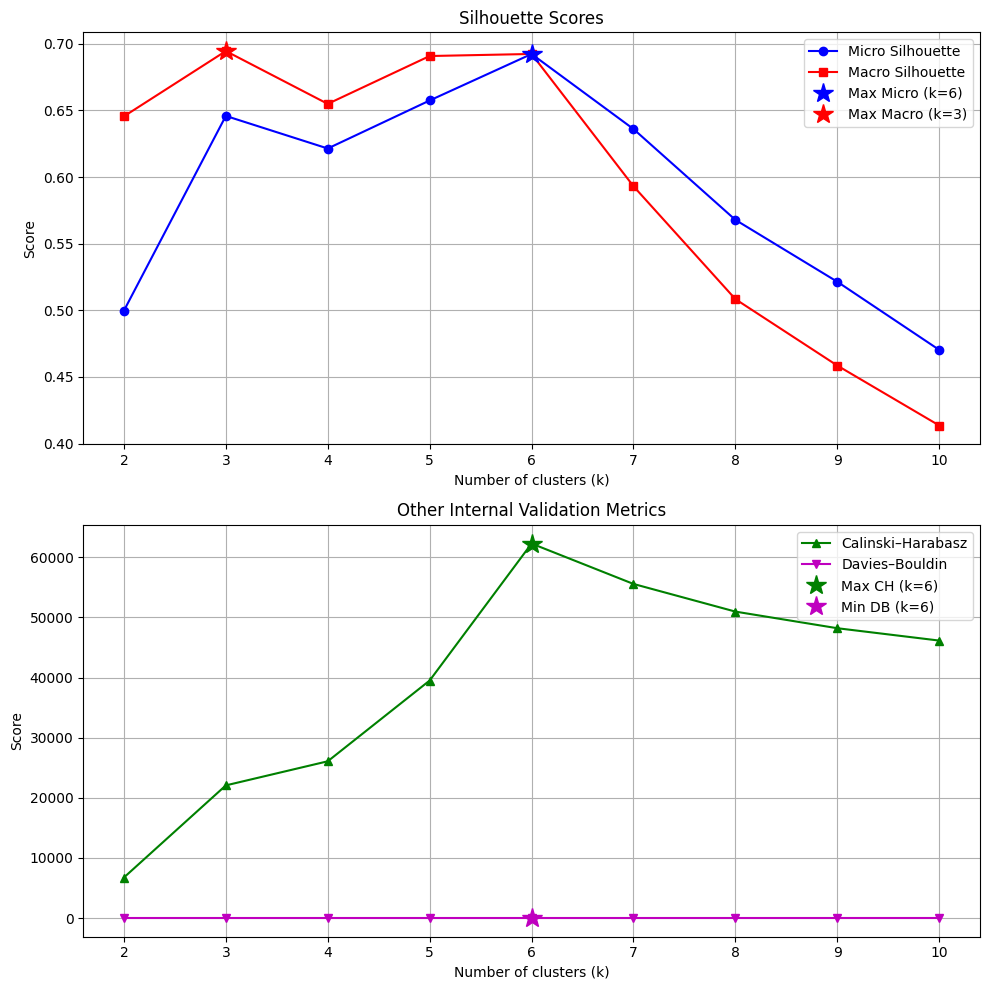

In [ ]:
data, true_labels = make_blobs(n_samples=10000, centers=6, cluster_std=0.9, random_state=20)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

results = evaluate_silhouette_scores(scaled_data, range(2, 11), 6)

s2


Metrics at ground-truth k = 5:
  - Micro Silhouette:       0.4852
  - Macro Silhouette:       0.7210
  - Calinski–Harabasz:      3879.45
  - Davies–Bouldin:         0.4848


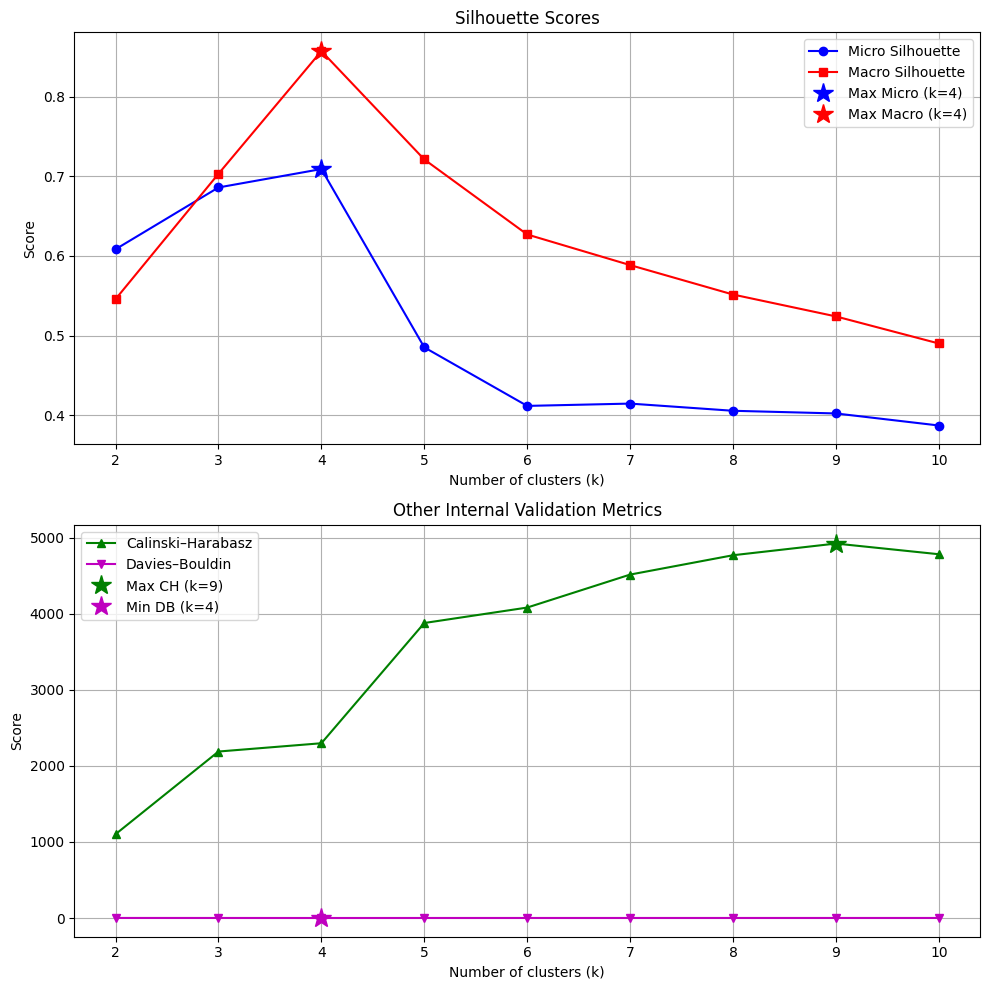

In [ ]:
cluster_sizes = [1000, 1000, 100, 100, 100]  # 2 large, 3 small
centers = [
    (0, 0),   # large cluster #1
    (3, 3),   # large cluster #2 (not too far from #1, so they merge in small k)
    (12, 12), # small cluster #1
    (-12, 12),# small cluster #2
    (0, 15),  # small cluster #3
]
stds = [1.8, 1.8, 0.5, 0.5, 0.5]  # bigger std for large clusters, smaller for small

X, y = make_blobs(
    n_samples=cluster_sizes,
    centers=centers,
    cluster_std=stds,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = evaluate_silhouette_scores(X_scaled, range(2, 11), 5)

s3


Metrics at ground-truth k = 12:
  - Micro Silhouette:       0.4086
  - Macro Silhouette:       0.6681
  - Calinski–Harabasz:      7065.08
  - Davies–Bouldin:         0.4975


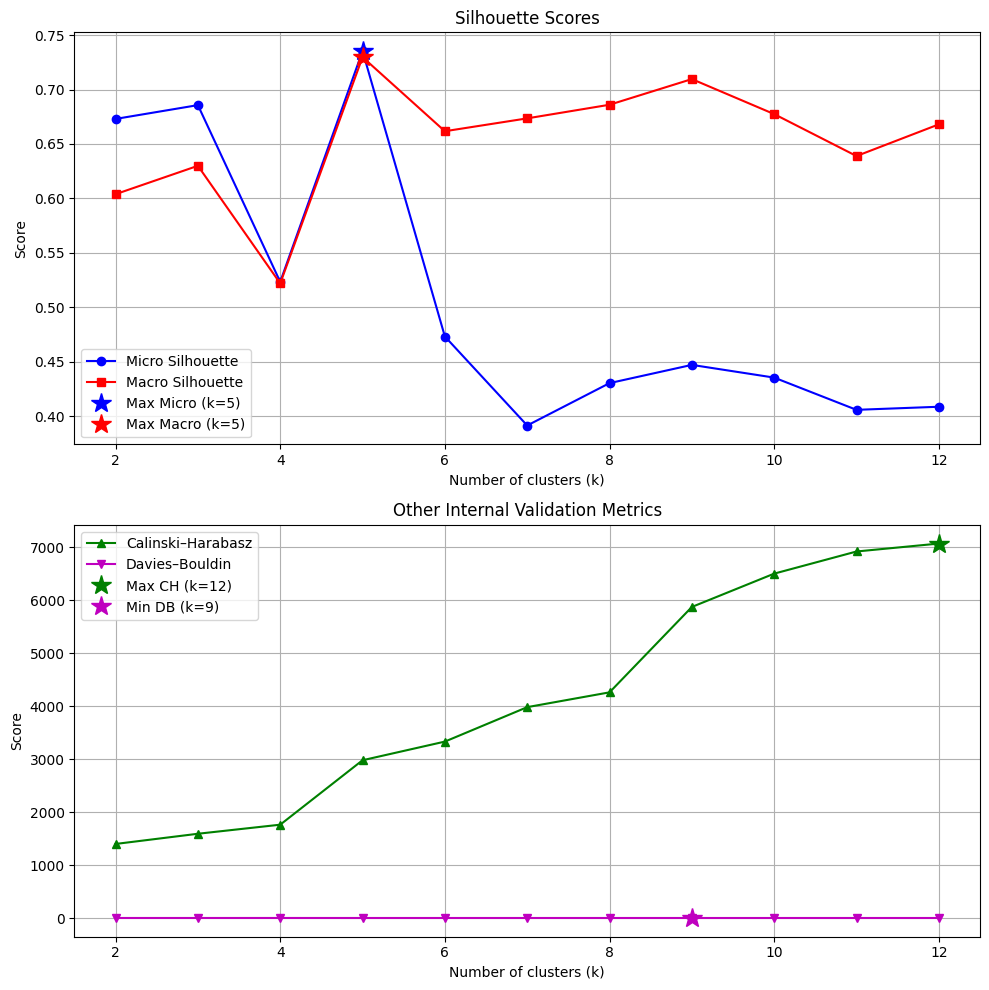

In [ ]:
cluster_sizes = [1500, 1500, 300, 300] + [80]*5 + [30]*3
# That’s a total of 4 (big+medium) + 5 small + 3 tiny = 12 clusters

centers = [
    # Large clusters near each other
    (0, 0),        # Large #1
    (3, 3),        # Large #2

    # Medium clusters
    (8, 0),        # Medium #1
    (0, 8),        # Medium #2

    # 5 small clusters
    (18, 18),
    (-18, 18),
    (18, -18),
    (-18, -18),
    (22, 0),

    # 3 tiny clusters placed very far away
    (0, 25),
    (25, 25),
    (25, -25)
]

# Standard deviations
# - Large clusters bigger spread
# - Medium smaller
# - Small even smaller
# - Tiny very small spread
stds = [
    2.2, 2.2,   # large
    1.2, 1.2,   # medium
    0.9, 0.9, 0.9, 0.9, 0.9,  # 5 small
    0.6, 0.6, 0.6             # 3 tiny
]

X_E, y_E = make_blobs(
    n_samples=cluster_sizes,
    centers=centers,
    cluster_std=stds,
    random_state=47
)

scaler = StandardScaler()
X_E_scaled = scaler.fit_transform(X_E)

results = evaluate_silhouette_scores(X_E_scaled, range(2, 13), 12)

wine


Metrics at ground-truth k = 3:
  - Micro Silhouette:       0.2849
  - Macro Silhouette:       0.2905
  - Calinski–Harabasz:      70.94
  - Davies–Bouldin:         1.3892


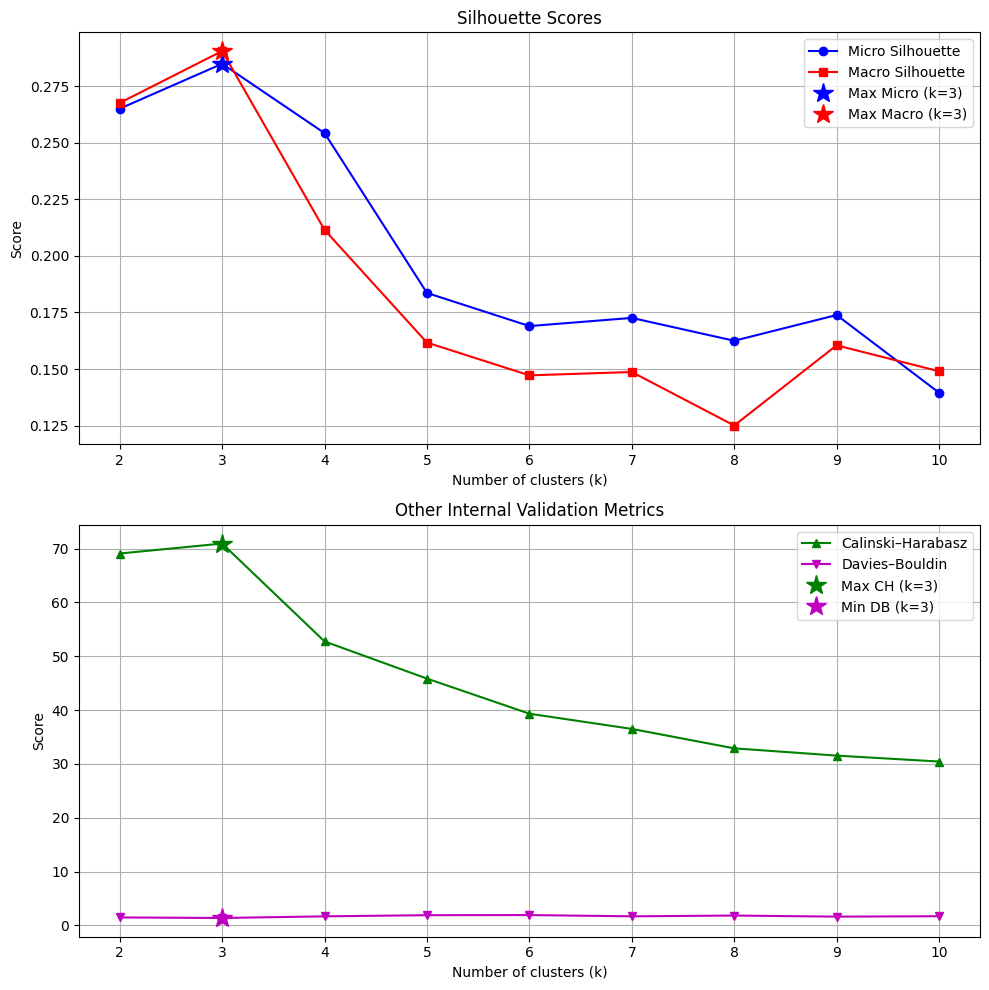

In [ ]:
data_wine = load_wine()
X_wine = data_wine.data
y_wine = data_wine.target
num_classes = len(set(y_wine))

scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)

results = evaluate_silhouette_scores(X_wine_scaled, range(2, 11), num_classes)

Glass


Metrics at ground-truth k = 6:
  - Micro Silhouette:       0.3307
  - Macro Silhouette:       0.3781
  - Calinski–Harabasz:      62.35
  - Davies–Bouldin:         1.0123


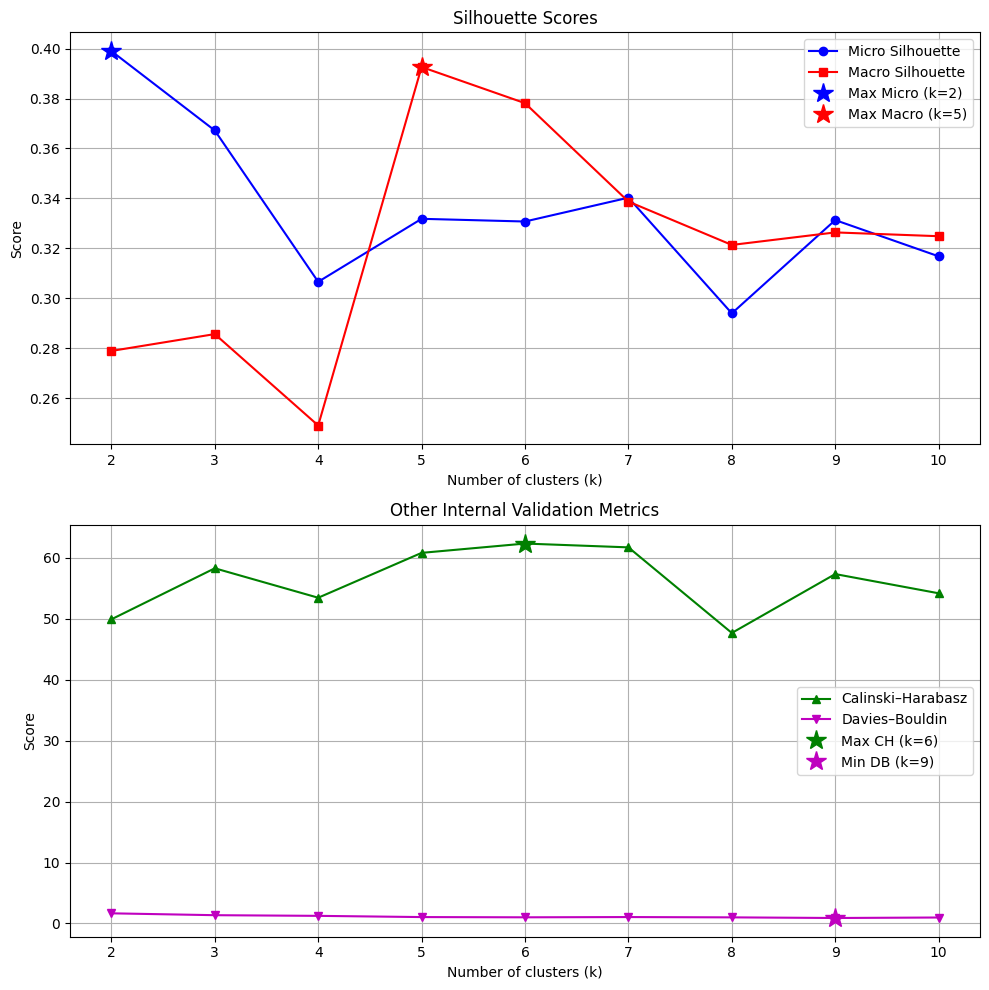

In [ ]:
from sklearn.datasets import fetch_openml

data_glass = fetch_openml(name='Glass', version=1, as_frame=False)
X_glass = data_glass.data
y_glass = data_glass.target
num_classes = len(np.unique(y_glass))
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_glass_scaled = scaler.fit_transform(X_glass)
results = evaluate_silhouette_scores(X_glass_scaled, range(2, 11), gt_k=num_classes)

Pendigits


Metrics at ground-truth k = 10:
  - Micro Silhouette:       0.3416
  - Macro Silhouette:       0.3381
  - Calinski–Harabasz:      4153.82
  - Davies–Bouldin:         1.0583


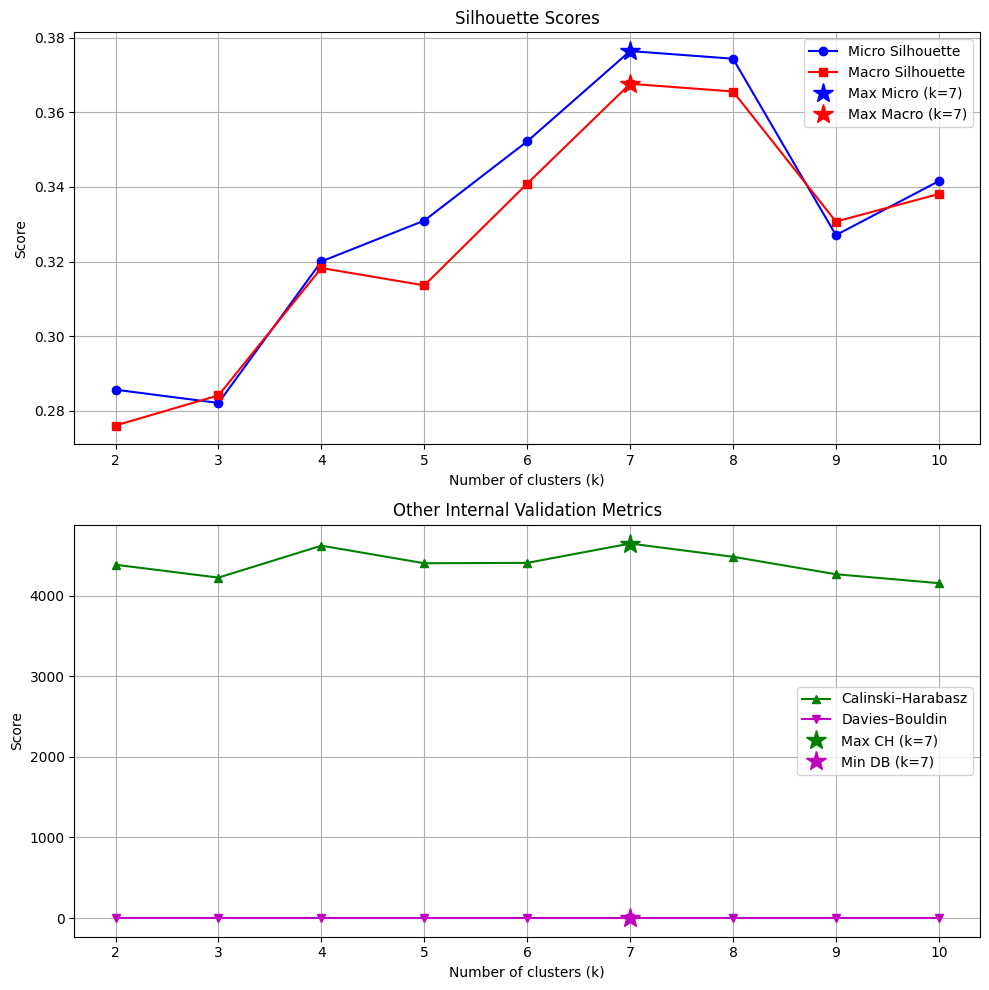

In [ ]:
data_pendigits = fetch_openml(name='pendigits', version=1, as_frame=False)
X_pendigits = data_pendigits.data
y_pendigits = data_pendigits.target
num_classes = len(set(y_pendigits))

scaler = StandardScaler()
X_pendigits_scaled = scaler.fit_transform(X_pendigits)

pca = PCA(n_components=0.8)
X_pendigits_reduced = pca.fit_transform(X_pendigits_scaled)

results = evaluate_silhouette_scores(X_pendigits_reduced, range(2, 11), num_classes)

Cifar


Metrics at ground-truth k = 10:
  - Micro Silhouette:       0.0473
  - Macro Silhouette:       0.0478
  - Calinski–Harabasz:      2921.16
  - Davies–Bouldin:         2.8273


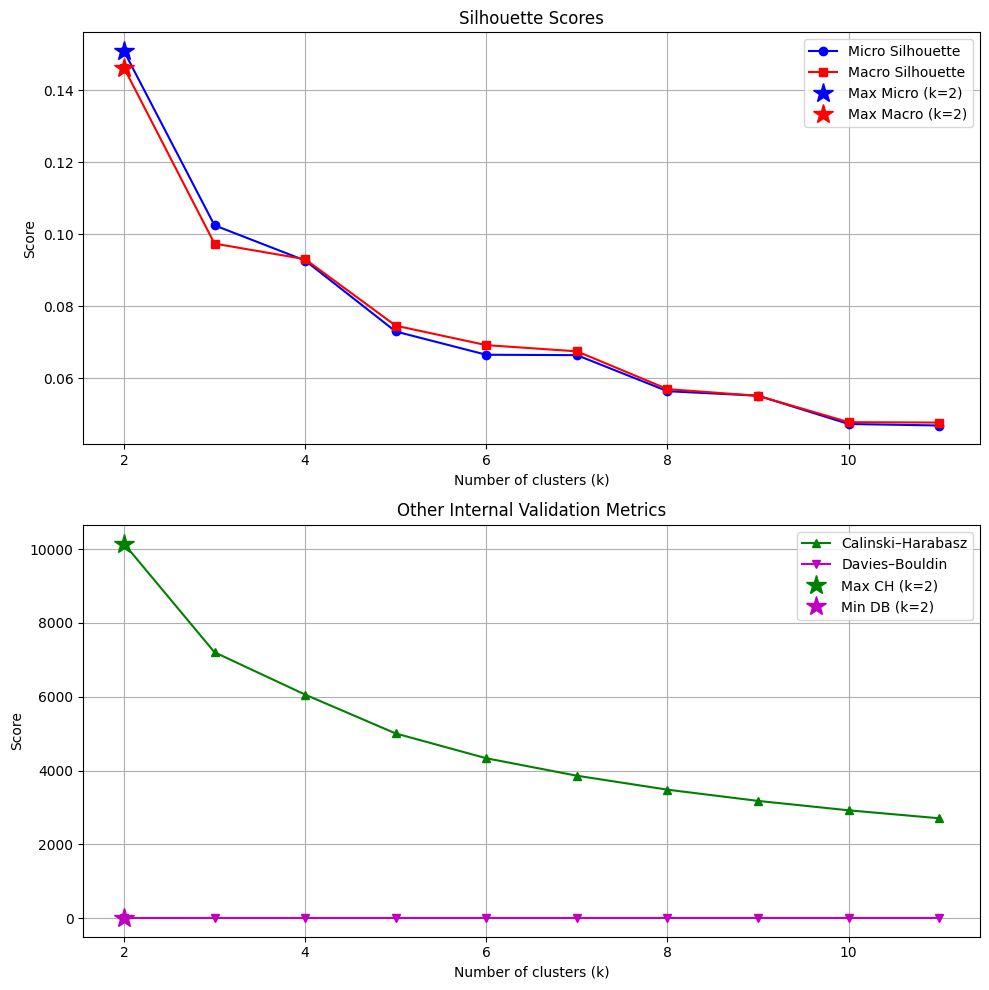

In [ ]:
(X_cifar_train, y_cifar_train), _ = cifar10.load_data()

X_cifar_flat = X_cifar_train.reshape(X_cifar_train.shape[0], -1)
X_cifar_scaled = StandardScaler().fit_transform(X_cifar_flat)
y_cifar = y_cifar_train.flatten()
num_classes_cifar = len(np.unique(y_cifar))

results = evaluate_silhouette_scores(X_cifar_scaled, range(2, 12), num_classes_cifar)

20 News


Metrics at ground-truth k = 20:
  - Micro Silhouette:       0.9928
  - Macro Silhouette:       0.0497
  - Calinski–Harabasz:      2756.91
  - Davies–Bouldin:         0.0019


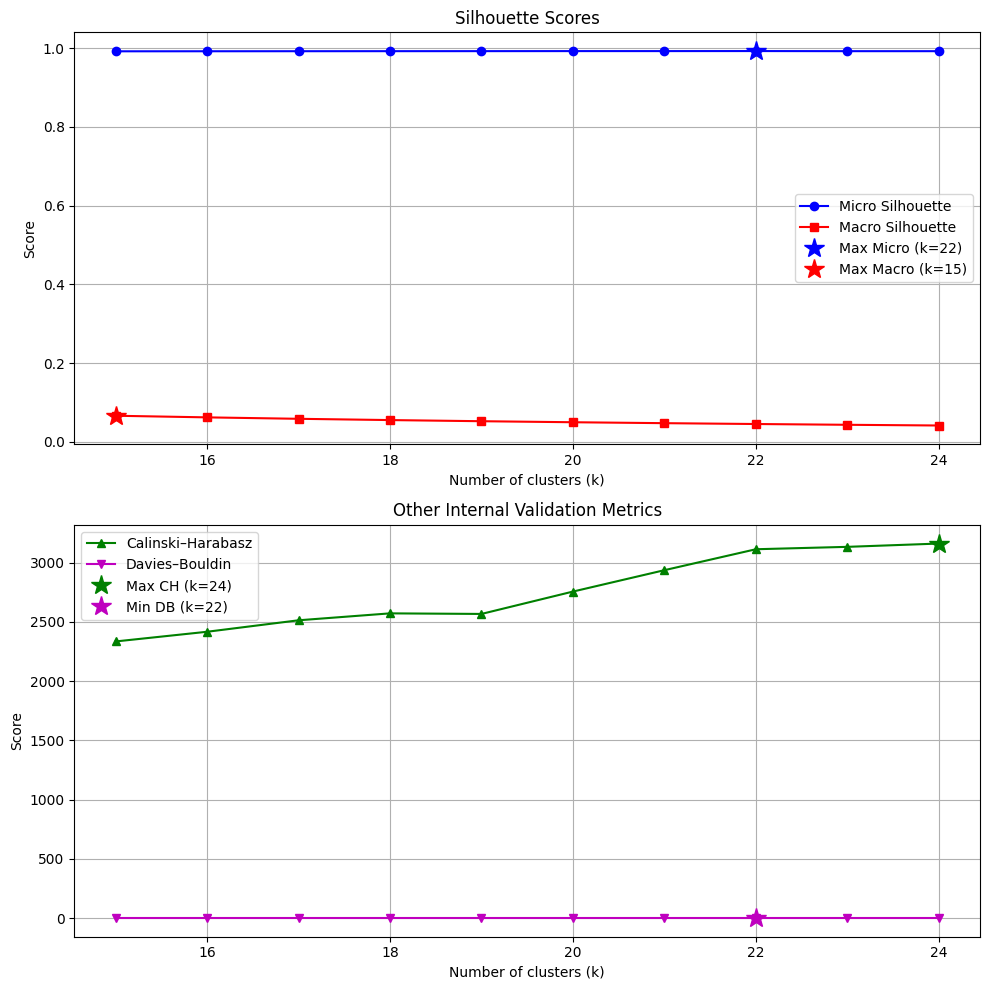

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data_20ng = fetch_20newsgroups(subset='train')
num_classes_20ng = 20

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data_20ng.data)

X_dense = X_tfidf.toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

results = evaluate_silhouette_scores(X_pca, range(15, 25), num_classes_20ng)

Ionosphere


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.2704
  - Macro Silhouette:       0.2507
  - Calinski–Harabasz:      95.91
  - Davies–Bouldin:         1.6819


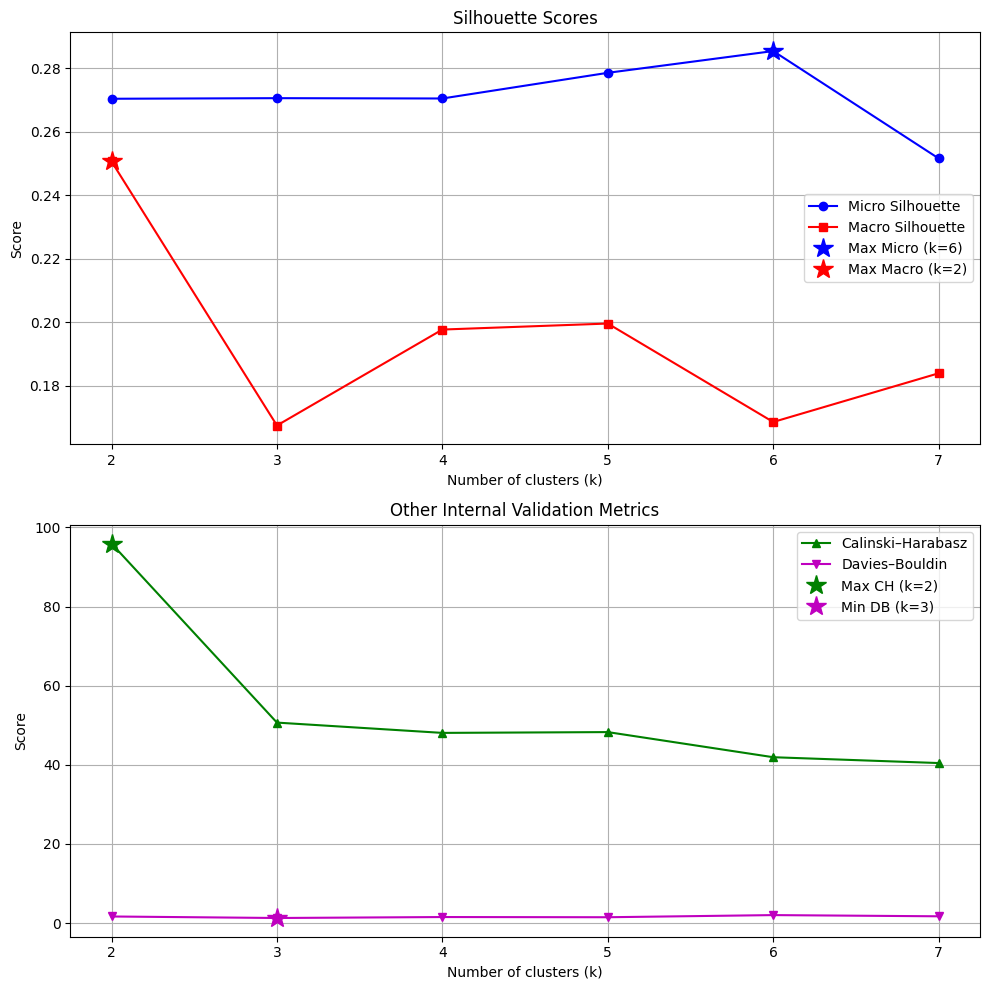

In [ ]:
data_iono = fetch_openml(name='ionosphere', version=1, as_frame=False)
X_bc = StandardScaler().fit_transform(data_iono.data)
num_classes_bc = len(set(data_iono.target))

results = evaluate_silhouette_scores(X_bc, range(2, 8), num_classes_bc)

Digits


Metrics at ground-truth k = 10:
  - Micro Silhouette:       0.1767
  - Macro Silhouette:       0.1806
  - Calinski–Harabasz:      162.57
  - Davies–Bouldin:         2.0463


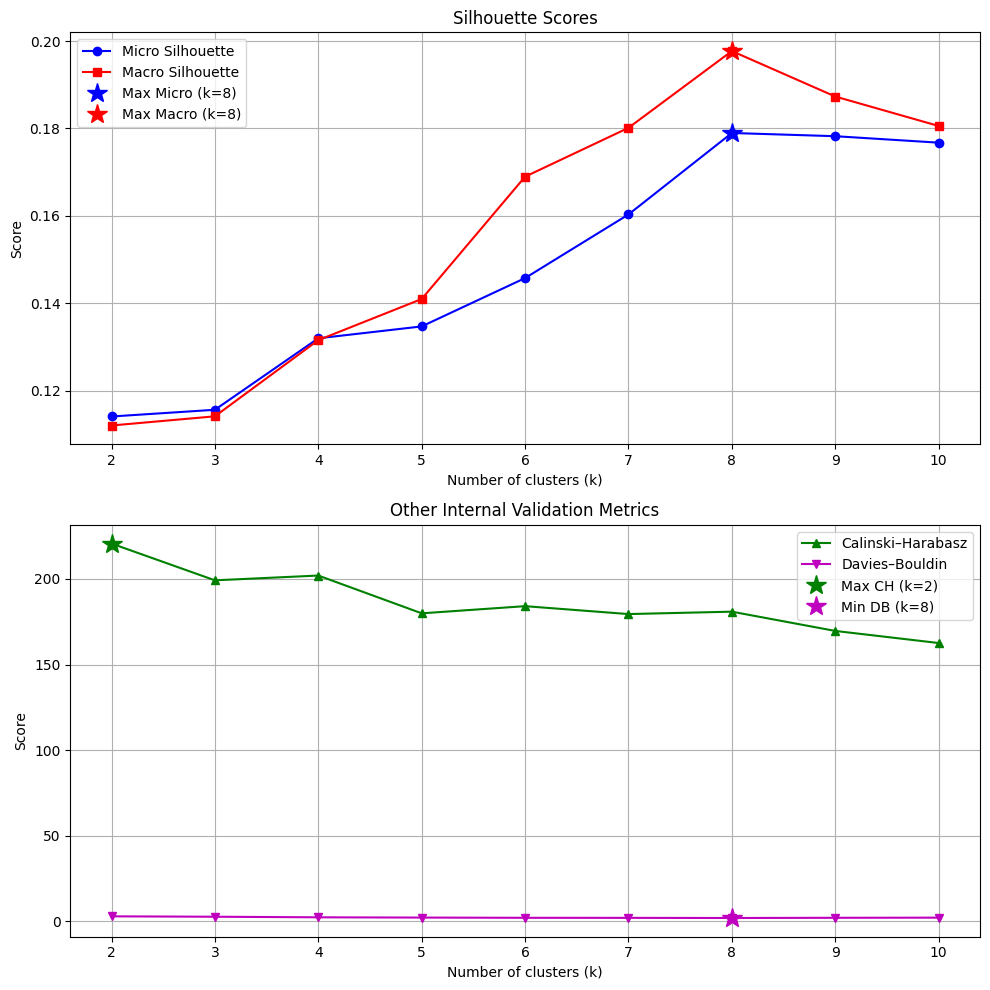

In [ ]:
data_digits = load_digits()
X_digits = data_digits.data

pca = PCA(n_components=0.999)
X_digits_reduced = pca.fit_transform(X_digits)

results = evaluate_silhouette_scores(X_digits_reduced, range(2, 11), 10)

BankNote


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.3291
  - Macro Silhouette:       0.3289
  - Calinski–Harabasz:      807.20
  - Davies–Bouldin:         1.2000


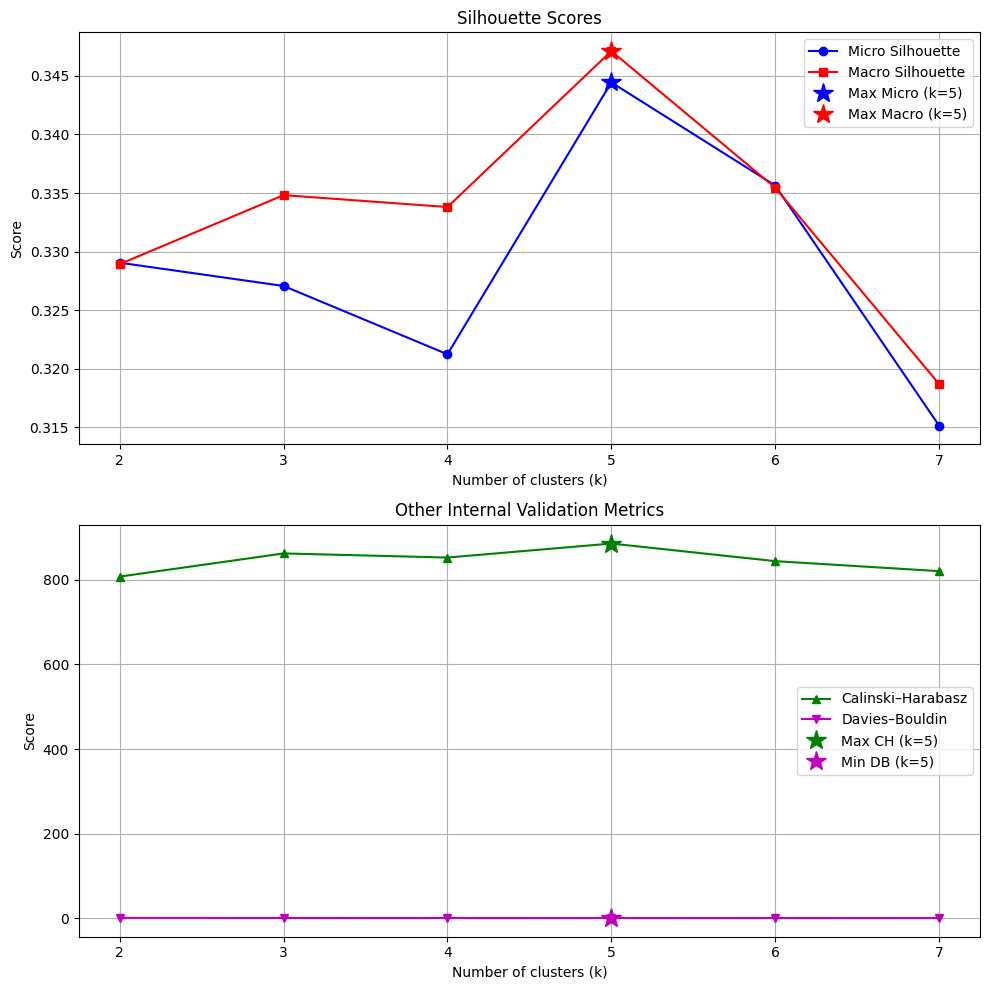

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np

data_banknote = fetch_openml(name='banknote-authentication', version=1, as_frame=False)
X_banknote = StandardScaler().fit_transform(data_banknote.data)
y_banknote = data_banknote.target.astype(int)
num_classes_banknote = len(np.unique(y_banknote))

X_banknote.shape, num_classes_banknote

X_bc = StandardScaler().fit_transform(data_banknote.data)
num_classes_bc = len(set(data_banknote.target))

results = evaluate_silhouette_scores(X_bc, range(2, 8), 2)

Blood Transfusion


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.4543
  - Macro Silhouette:       0.3822
  - Calinski–Harabasz:      438.83
  - Davies–Bouldin:         0.9798


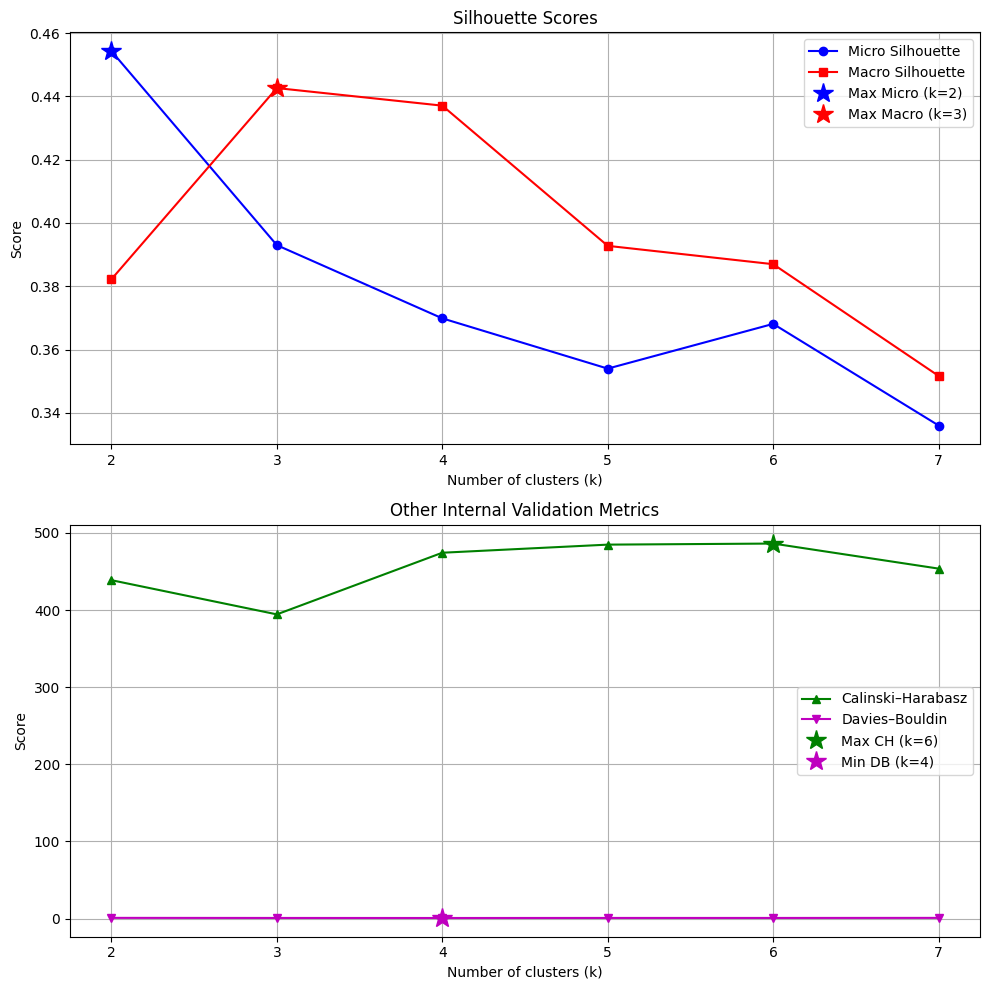

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_blood = fetch_openml(name='blood-transfusion-service-center', version=1, as_frame=True)
X_blood = data_blood.data
y_blood_raw = data_blood.target

le = LabelEncoder()
y_blood = le.fit_transform(y_blood_raw)
num_classes_blood = len(np.unique(y_blood))

X_blood_scaled = StandardScaler().fit_transform(X_blood)

results = evaluate_silhouette_scores(X_blood_scaled, range(2, 8), num_classes_blood)

Parkinsons


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.4373
  - Macro Silhouette:       0.3308
  - Calinski–Harabasz:      100.90
  - Davies–Bouldin:         1.0802


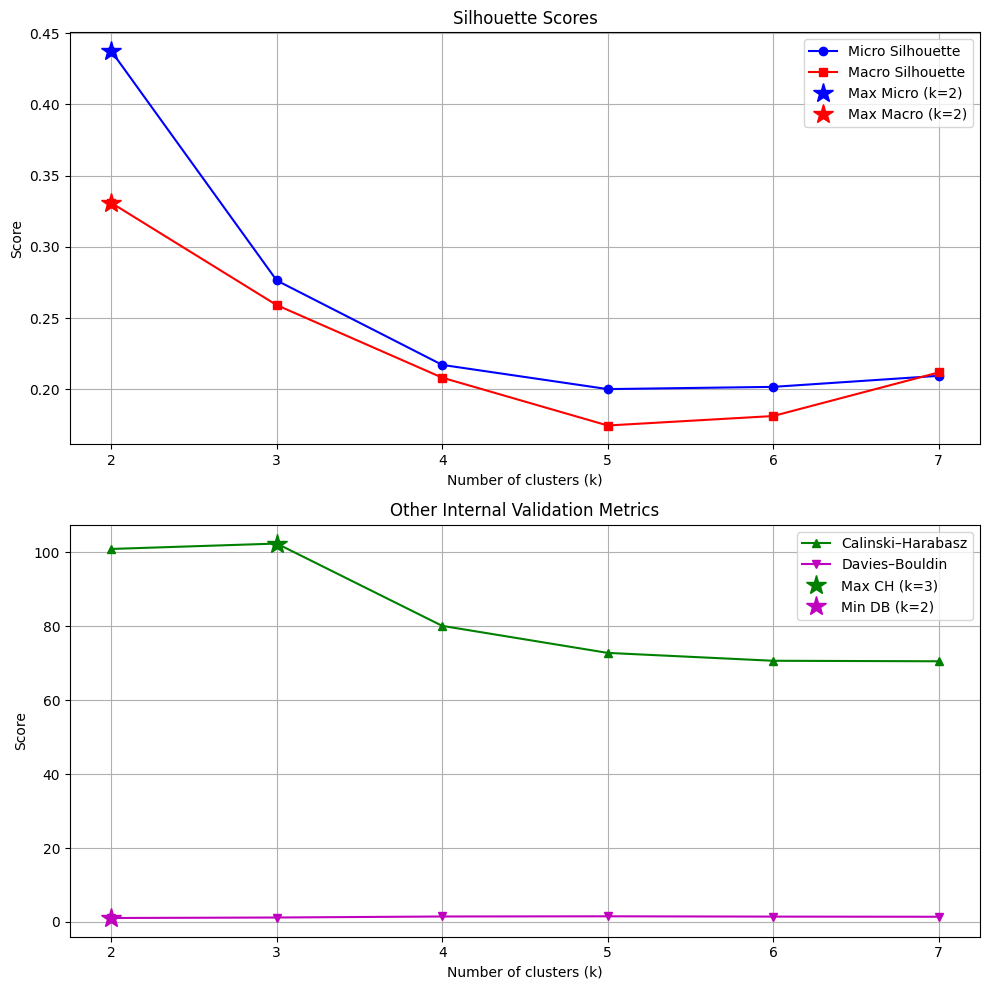

In [ ]:
data_parkinson = fetch_openml(name='parkinsons', version=1, as_frame=True)
X_parkinson = data_parkinson.data
y_parkinson_raw = data_parkinson.target

le_parkinson = LabelEncoder()
y_parkinson = le_parkinson.fit_transform(y_parkinson_raw)
num_classes_parkinson = len(np.unique(y_parkinson))

X_parkinson_scaled = StandardScaler().fit_transform(X_parkinson)

results = evaluate_silhouette_scores(X_parkinson_scaled, range(2, 8), 2)

HTRU2


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.6010
  - Macro Silhouette:       0.4042
  - Calinski–Harabasz:      9891.65
  - Davies–Bouldin:         1.0558


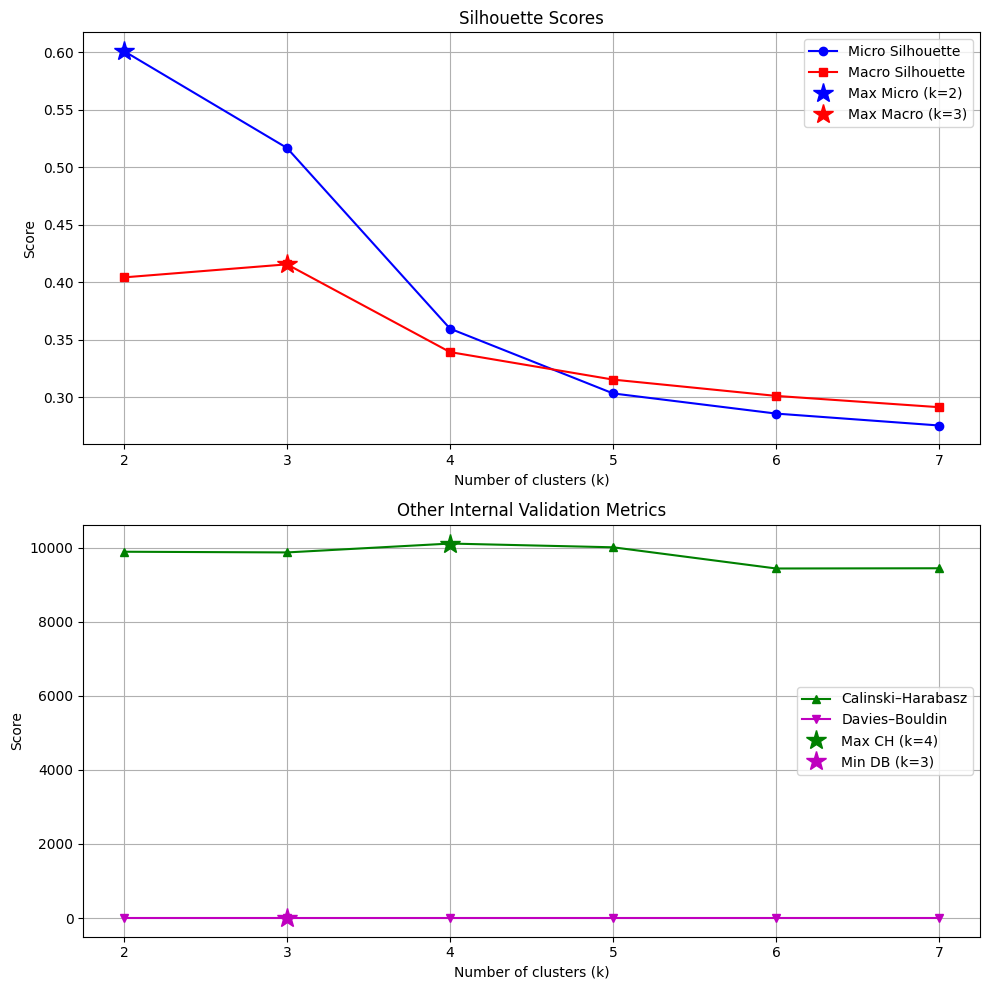

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

htru2 = fetch_ucirepo(id=372)
X_htru2 = htru2.data.features.to_numpy()
y_raw_htru2 = htru2.data.targets.iloc[:, 0]  # Single binary column

le_htru2 = LabelEncoder()
y_htru2 = le_htru2.fit_transform(y_raw_htru2)
num_classes_htru2 = len(np.unique(y_htru2))

X_htru2_scaled = StandardScaler().fit_transform(X_htru2)

results = evaluate_silhouette_scores(X_htru2_scaled, range(2, 8), 2)

Spambase


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.6596
  - Macro Silhouette:       0.5720
  - Calinski–Harabasz:      374.09
  - Davies–Bouldin:         0.6127


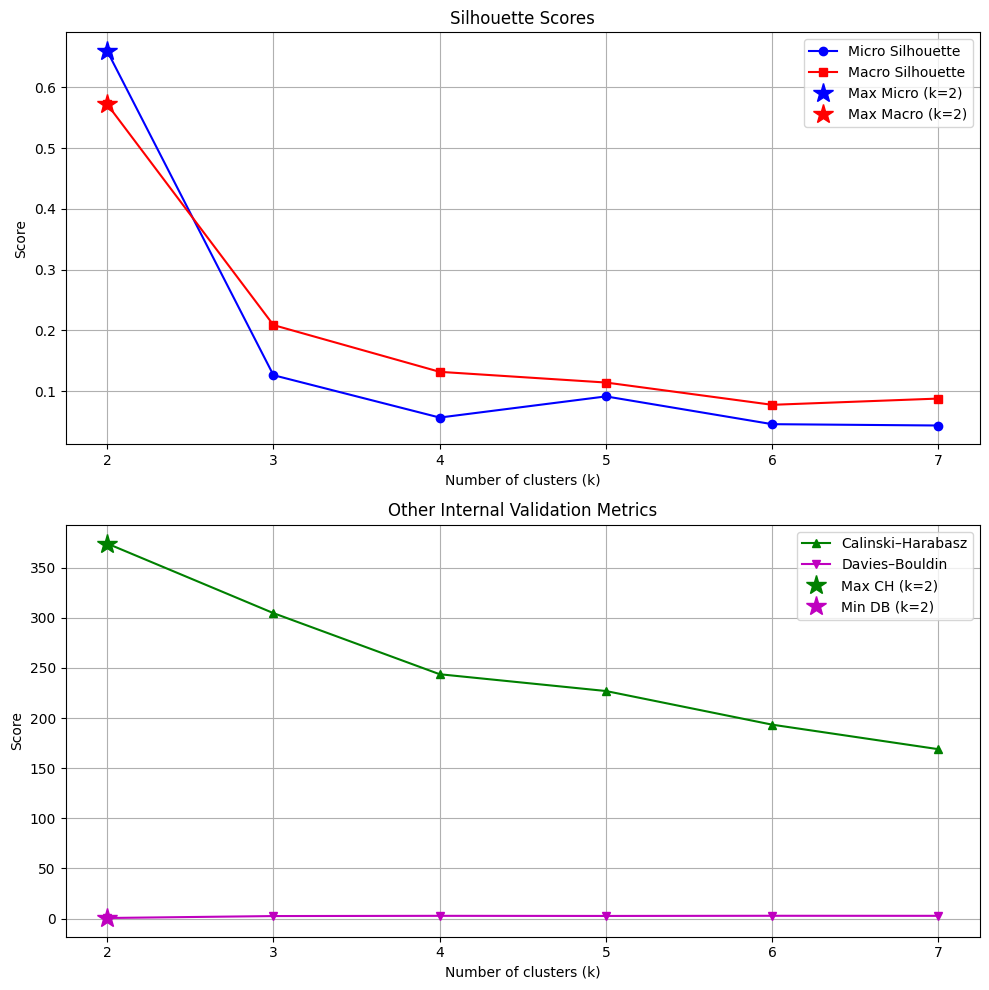

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_spambase = fetch_openml(name='spambase', version=1, as_frame=True)
X_spambase = data_spambase.data
y_spambase_raw = data_spambase.target

le_spam = LabelEncoder()
y_spambase = le_spam.fit_transform(y_spambase_raw)
num_classes_spambase = len(np.unique(y_spambase))

X_spambase_scaled = StandardScaler().fit_transform(X_spambase)

results = evaluate_silhouette_scores(X_spambase_scaled, range(2, 8), num_classes_spambase)

Bank Marketing


Metrics at ground-truth k = 2:
  - Micro Silhouette:       0.1619
  - Macro Silhouette:       0.1603
  - Calinski–Harabasz:      5980.59
  - Davies–Bouldin:         2.2604


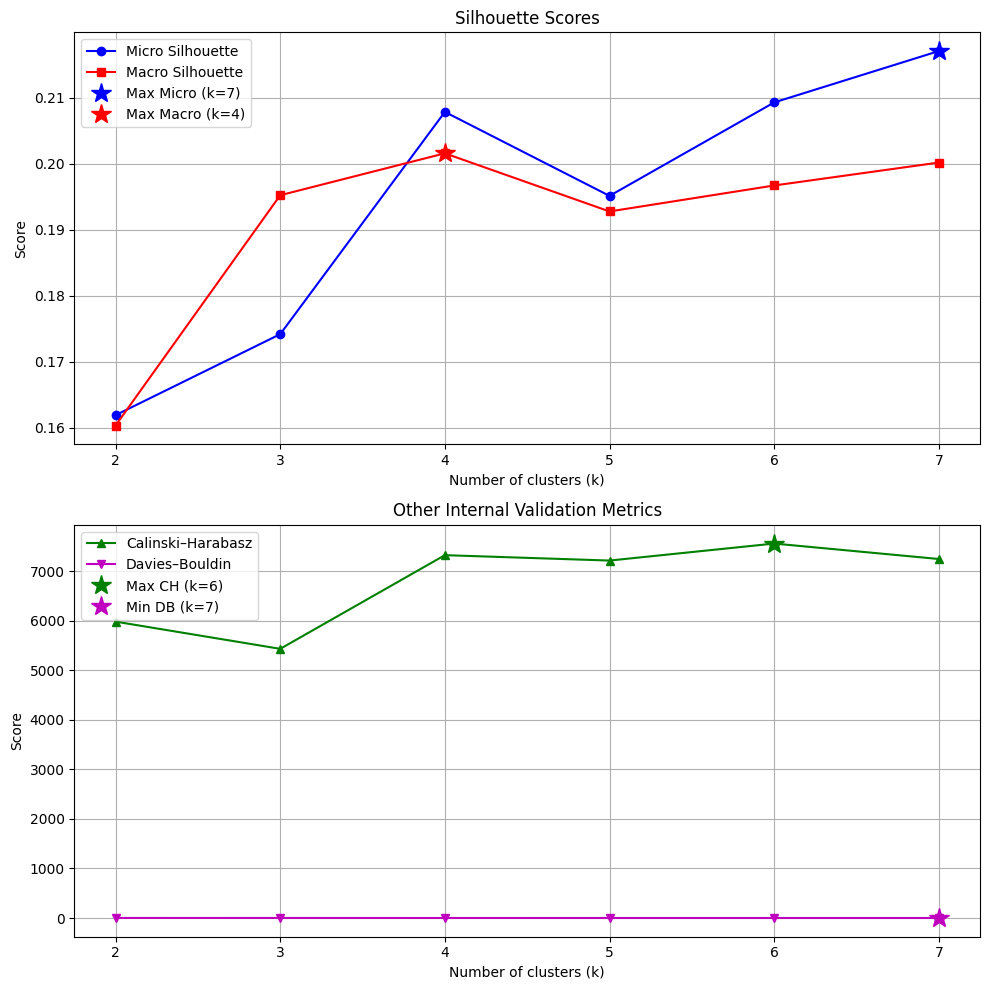

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

data_bank = fetch_openml(name='bank-marketing', version=1, as_frame=True)
X_bank = data_bank.data.select_dtypes(include=[np.number])  # numeric features only
y_bank_raw = data_bank.target

le_bank = LabelEncoder()
y_bank = le_bank.fit_transform(y_bank_raw)
num_classes_bank = len(np.unique(y_bank))

X_bank_scaled = StandardScaler().fit_transform(X_bank)

results = evaluate_silhouette_scores(X_bank_scaled, range(2, 8), num_classes_bank)